In [1]:
# ATTENTION: Please do not alter any of the provided code in the exercise. Only add your own code where indicated
# ATTENTION: Please do not add or remove any cells in the exercise. The grader will check specific cells based on the cell position.
# ATTENTION: Please use the provided epoch values when training.

# In this exercise you will train a CNN on the FULL Cats-v-dogs dataset
# This will require you doing a lot of data preprocessing because
# the dataset isn't split into training and validation for you
# This code block has all the required inputs
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile
from os import getcwd

In [2]:
# This code block unzips the full Cats-v-Dogs dataset to /tmp
# which will create a tmp/PetImages directory containing subdirectories
# called 'Cat' and 'Dog' (that's how the original researchers structured it)
path_cats_and_dogs = f"{getcwd()}/../tmp2/cats-and-dogs.zip"
shutil.rmtree('/tmp')

local_zip = path_cats_and_dogs
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [3]:
print(len(os.listdir('/tmp/PetImages/Cat/')))
print(len(os.listdir('/tmp/PetImages/Dog/')))

# Expected Output:
# 1500
# 1500

1500
1500


In [4]:
# Use os.mkdir to create your directories
# You will need a directory for cats-v-dogs, and subdirectories for training
# and testing. These in turn will need subdirectories for 'cats' and 'dogs'
try:
    os.mkdir("/tmp/cats-v-dogs")
    os.mkdir("/tmp/cats-v-dogs/training")
    os.mkdir("/tmp/cats-v-dogs/training/cats")
    os.mkdir("/tmp/cats-v-dogs/training/dogs")
    os.mkdir("/tmp/cats-v-dogs/testing")
    os.mkdir("/tmp/cats-v-dogs/testing/cats")
    os.mkdir("/tmp/cats-v-dogs/testing/dogs")
except OSError:
    pass

In [5]:
# Write a python function called split_data which takes
# a SOURCE directory containing the files
# a TRAINING directory that a portion of the files will be copied to
# a TESTING directory that a portion of the files will be copie to
# a SPLIT SIZE to determine the portion
# The files should also be randomized, so that the training set is a random
# X% of the files, and the test set is the remaining files
# SO, for example, if SOURCE is PetImages/Cat, and SPLIT SIZE is .9
# Then 90% of the images in PetImages/Cat will be copied to the TRAINING dir
# and 10% of the images will be copied to the TESTING dir
# Also -- All images should be checked, and if they have a zero file length,
# they will not be copied over
#
# os.listdir(DIRECTORY) gives you a listing of the contents of that directory
# os.path.getsize(PATH) gives you the size of the file
# copyfile(source, destination) copies a file from source to destination
# random.sample(list, len(list)) shuffles a list
def split_data(SOURCE, TRAINING, TESTING, SPLIT_SIZE):
# YOUR CODE STARTS HERE
    random.seed(1)
    allfiles = os.listdir(SOURCE)
    
    # discard any file with a zero file length
    allfiles_nozero = [f for f in allfiles if os.path.getsize(SOURCE + f) > 0]
    
    # split training & testing
    portion_split = int(len(allfiles_nozero)*SPLIT_SIZE)
    train_files = random.sample(allfiles_nozero, portion_split)
    test_files = list(set(allfiles_nozero).symmetric_difference(set(train_files)))
    
    # copy the relevant files to TRAINING dir
    for f in train_files:
        copyfile(SOURCE + f, TRAINING + f)
    
    # copy the relevant files to TESTING dir
    for f in test_files:
        copyfile(SOURCE + f, TESTING + f)
# YOUR CODE ENDS HERE


CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAINING_CATS_DIR = "/tmp/cats-v-dogs/training/cats/"
TESTING_CATS_DIR = "/tmp/cats-v-dogs/testing/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAINING_DOGS_DIR = "/tmp/cats-v-dogs/training/dogs/"
TESTING_DOGS_DIR = "/tmp/cats-v-dogs/testing/dogs/"

split_size = .9
split_data(CAT_SOURCE_DIR, TRAINING_CATS_DIR, TESTING_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAINING_DOGS_DIR, TESTING_DOGS_DIR, split_size)

In [6]:
print(len(os.listdir('/tmp/cats-v-dogs/training/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/training/dogs/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/cats/')))
print(len(os.listdir('/tmp/cats-v-dogs/testing/dogs/')))

# Expected output:
# 1350
# 1350
# 150
# 150

1350
1350
150
150


In [8]:
train_cats_dir = '/tmp/cats-v-dogs/training/cats'
train_dogs_dir = '/tmp/cats-v-dogs/training/dogs'

train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )

In [9]:
%matplotlib inline

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

pic_index = 0 # Index for iterating over images

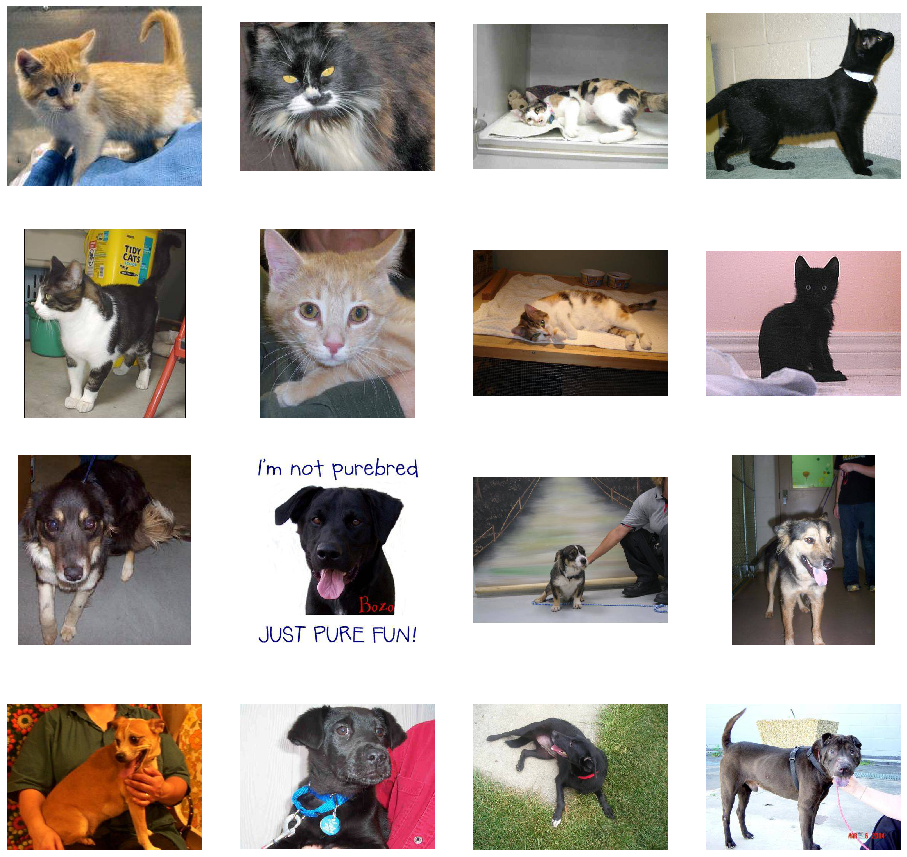

In [16]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index+=8

next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [6]:
# DEFINE A KERAS MODEL TO CLASSIFY CATS V DOGS
# USE AT LEAST 3 CONVOLUTION LAYERS
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (5,5), activation=tf.keras.layers.LeakyReLU(alpha=0.1), input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (4,4), activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
    tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(256, (2,2), activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
#     tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
    tf.keras.layers.Dense(16, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
#     tf.keras.layers.Dense(8, activation=tf.keras.layers.LeakyReLU(alpha=0.1)),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['acc'])

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 146, 146, 16)      1216      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 73, 73, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 70, 70, 32)        8224      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 35, 35, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 33, 33, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 128)       7

# NOTE:

In the cell below you **MUST** use a batch size of 10 (`batch_size=10`) for the `train_generator` and the `validation_generator`. Using a batch size greater than 10 will exceed memory limits on the Coursera platform.

In [8]:
TRAINING_DIR = os.path.join('/tmp/cats-v-dogs', 'training')
train_datagen = ImageDataGenerator(rescale=1/255, 
                                   rotation_range=50, 
                                   width_shift_range=0.3, 
                                   height_shift_range=0.3, 
                                   shear_range=0.3, 
                                   zoom_range=0.3, 
                                   horizontal_flip=True, 
                                   vertical_flip=True, 
                                   fill_mode='nearest')

# NOTE: YOU MUST USE A BATCH SIZE OF 10 (batch_size=10) FOR THE 
# TRAIN GENERATOR.
train_generator = train_datagen.flow_from_directory(TRAINING_DIR, batch_size=10, target_size=(150,150), classes=['cats','dogs'], class_mode='binary')

VALIDATION_DIR = os.path.join('/tmp/cats-v-dogs', 'testing')
validation_datagen = ImageDataGenerator(rescale=1/255)

# NOTE: YOU MUST USE A BACTH SIZE OF 10 (batch_size=10) FOR THE 
# VALIDATION GENERATOR.
validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR, batch_size=10, target_size=(150,150), classes=['cats','dogs'], class_mode='binary')



# Expected Output:
# Found 2700 images belonging to 2 classes.
# Found 300 images belonging to 2 classes.

Found 2700 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


In [13]:
train_iter = iter(train_generator)
batch = next(train_iter)

In [14]:
print(batch[0].shape)
single_img = batch[0][0]

(10, 150, 150, 3)


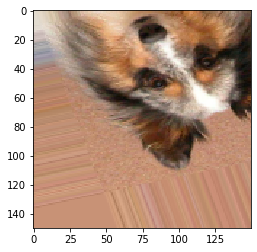

In [15]:
plt.imshow(single_img)

In [10]:
history = model.fit_generator(train_generator,
                              epochs=30,
                              verbose=1,
                              validation_data=validation_generator)

Epoch 1/30
270/270 [==============================] - 60s 222ms/step - loss: 0.6809 - acc: 0.5933 - val_loss: 0.7403 - val_acc: 0.5133
Epoch 2/30
270/270 [==============================] - 60s 222ms/step - loss: 0.7104 - acc: 0.5856 - val_loss: 0.6379 - val_acc: 0.6167
Epoch 3/30
270/270 [==============================] - 60s 222ms/step - loss: 0.6870 - acc: 0.6037 - val_loss: 0.6548 - val_acc: 0.6533
Epoch 4/30
270/270 [==============================] - 59s 219ms/step - loss: 0.6684 - acc: 0.5922 - val_loss: 0.6125 - val_acc: 0.6667
Epoch 5/30
270/270 [==============================] - 63s 234ms/step - loss: 0.6690 - acc: 0.6089 - val_loss: 0.6710 - val_acc: 0.5533
Epoch 6/30
270/270 [==============================] - 59s 219ms/step - loss: 0.6804 - acc: 0.6059 - val_loss: 0.6197 - val_acc: 0.6467
Epoch 7/30
270/270 [==============================] - 57s 213ms/step - loss: 0.6655 - acc: 0.6193 - val_loss: 0.6008 - val_acc: 0.6733
Epoch 8/30
270/270 [==============================] - 5

No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0.5, 1.0, 'Training and validation loss')

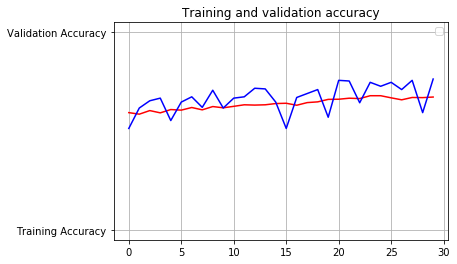

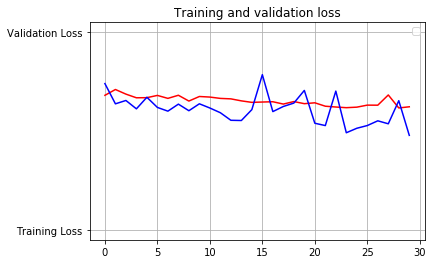

In [12]:
# PLOT LOSS AND ACCURACY
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.legend()
plt.grid()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.figure()
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.legend()
plt.grid()

plt.title('Training and validation loss')

# Desired output. Charts with training and validation metrics. No crash :)

# Submission Instructions

In [ ]:
# Now click the 'Submit Assignment' button above.

# When you're done or would like to take a break, please run the two cells below to save your work and close the Notebook. This will free up resources for your fellow learners. 

In [ ]:
%%javascript
<!-- Save the notebook -->
IPython.notebook.save_checkpoint();

In [ ]:
%%javascript
IPython.notebook.session.delete();
window.onbeforeunload = null
setTimeout(function() { window.close(); }, 1000);